### Importando bibliotecas

In [ ]:
# Processamento de imagens
import cv2
from skimage.measure import label
from skimage.io import imread, imshow,imsave
from skimage import color
from utils.preprocessing import *

# Manipulação de dados
import numpy as np
import pandas as pd

# Geração de gráficos
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pylab import rcParams
from matplotlib.colors import ListedColormap

# Machine Learning
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.model_selection  import train_test_split

# Gerais
from tqdm import tqdm

#### 1. Definir cores de interesse para a segmentação


OBSERVAÇÃO: H, hue in OpenCV varies from 0 to 180, but in the outer world it is usually measured in degrees from 0 to 360, so to get the H of your color h = 97.5° / 2 = 48.7

S and V are measured from 0 ( = 0% in outer world) to 255 ( = 100% in outer world), so

s = 255 * 5.1% = 13
v = 255 * 61.57% = 157

https://stackoverflow.com/questions/57469394/opencv-choosing-hsv-thresholds-for-color-filtering

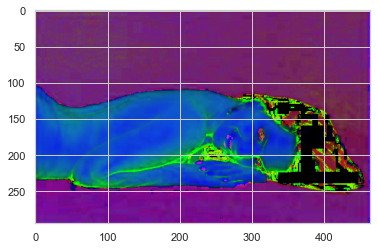

In [59]:
nudez = cv2.imread('./images/nudez.jpg')
nudez = cv2.cvtColor(nudez, cv2.COLOR_BGR2HSV)
plt.imshow(nudez)
plt.show()

#### 1.2 Pega H e S dos recortes de pele

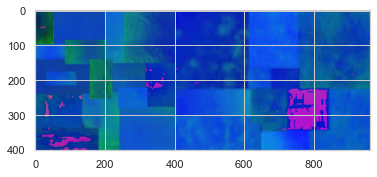

In [60]:
paleta = cv2.imread('./images/recorte_pele.jpg')
paleta = cv2.cvtColor(paleta, cv2.COLOR_BGR2HSV)
plt.imshow(paleta)
plt.show()

In [61]:
all_hsv_codes = paleta.reshape(-1, paleta.shape[-1])
all_hs_codes = [[h,s] for h,s,v in all_hsv_codes]
unique_hs = np.unique(all_hs_codes, axis=0)

unique_hs_x = [h*2 for h,s in unique_hs]
unique_hs_y = [s/255 for h,s in unique_hs]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


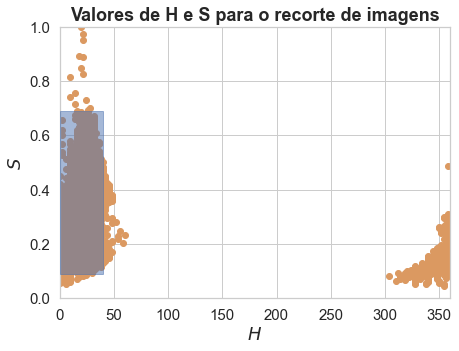

In [63]:
fig = plt.figure(figsize = (7,5))
sns.set_theme(style = 'whitegrid')

plt.xlabel('$H$', fontsize = 18)
plt.ylabel('$S$', fontsize = 18)

plt.xlim(0,360)
plt.ylim(0,1)

plt.scatter(unique_hs_x,unique_hs_y,c = '#DB9961')

plt.title(
    f'Valores de H e S para o recorte de imagens',
    fontsize= 18,
    fontweight = 'bold',
    y = 1
) 

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)

# Adicionando faixa de interesse
# Valor real (Open CV): H[0,20] e S[25,180]
plt.gca().add_patch(
   Rectangle(
       (0,0.09),
       40,
       0.6,
       fill=True, 
       color='b', 
       alpha=0.5, 
       zorder=100, 
       figure=fig
       )
   )

plt.savefig(
    f'./graficos/distribuicao_H_S.eps',
    dpi=1200,
    format = 'eps',
    bbox_inches='tight'
)

### 2 Segmentação de Cores

In [64]:
x = nudez.shape[0]
y = nudez.shape[1]

mask = np.zeros((x+1,y+1))

for i in range(0,x):
    for j in range(0,y):

        h,s,v = nudez[i,j,:]

        if (0 <= h <= 20) and (25 <= s <= 180):

            mask[i,j] = 1

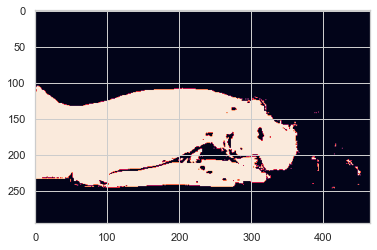

In [65]:
plt.imshow(mask)
plt.show()

#### 2.1 Opening e Closing

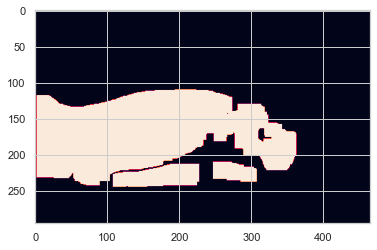

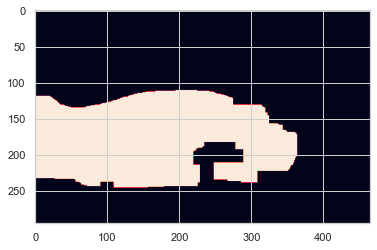

In [66]:
kernel = np.ones((18,18),np.uint8)
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
plt.imshow(opening)
plt.show()

closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing)
plt.show()

### 3 Rotulação e Contagem de Elementos Conectados

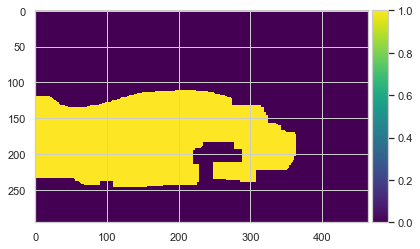

In [77]:
label_image = label(closing)
imshow(label_image)

### 4 Medição da Área do Maior Elemento Conectado

In [11]:
flat_label_image = label_image.flatten()

# Número de regiões
num_regioes = max(flat_label_image)

In [12]:
regioes_dict = {}

# não leva em conta os que tem indice 0
for i in range(1,int(num_regioes)+1):

    regioes_dict[str(i)] = len(np.where(flat_label_image == i)[0])

lista_chaves = list(regioes_dict.keys())
lista_valores = list(regioes_dict.values())
 
position = lista_valores.index(max(lista_valores))
maior_regiao_indice = lista_chaves[position]

area_imagem = x*y
area_regiao = regioes_dict[maior_regiao_indice]

porcentagem_ocupada = (area_regiao/area_imagem)*100

In [14]:
porcentagem_ocupada

27.82437171244886

### 5 Classificação por meio de Aprendizado de Máquina

In [ ]:
dataset = pd.DataFrame(columns=['area_ocupada','numero_regioes','label'])

#### 5.1 Pega dataset nudez

In [2]:
nsfw_urls = []
with open('./images/urls_nsfw.txt','r') as f:
    nsfw_urls = [line.rstrip() for line in f]

In [20]:
index = 0
while dataset.shape[0] < 500:

    url = nsfw_urls[index]

    try:
        imagem = read_image(url)
        mask,x,y = apply_mask(imagem)
        closing = opening_closing(mask)
        num_regioes,porcentagem_ocupada = label_image(closing,x,y)

        nova_linha = pd.Series(
            {
                'area_ocupada': porcentagem_ocupada, 
                'numero_regioes': num_regioes,
                'label':1
            }    
        )

        dataset = pd.concat(
            [
                dataset,
                nova_linha.to_frame().T,
            ],
            ignore_index=True
            )

    except Exception as e:
        print(e)
    finally:
        index += 1

[WinError 32] O arquivo já está sendo usado por outro processo: 'C:\\Users\\erica\\AppData\\Local\\Temp\\tmpi2ayplw4.jpg'


#### 5.2 Pega dataset vestidas

In [52]:
for index in tqdm(range(1,501),desc='Progress'):
    try:

        file_index = str(index)

        while len(file_index) < 4:
            file_index = '0' + file_index 

        imagem = read_image(f'./images/imagens_vestidas/img_{file_index}.png')
        mask,x,y = apply_mask(imagem)
        closing = opening_closing(mask)
        num_regioes,porcentagem_ocupada = label_image(closing,x,y)

        nova_linha = pd.Series(
            {
                'area_ocupada': porcentagem_ocupada, 
                'numero_regioes': num_regioes,
                'label':0
            }    
        )

        dataset = pd.concat(
            [
                dataset,
                nova_linha.to_frame().T,
            ],
            ignore_index=True
            )

    except Exception as e:
        print(e)

Progress: 100%|██████████| 500/500 [16:39<00:00,  2.00s/it]


In [80]:
dataset.to_csv('./data/resultado.csv')

### Treinando modelo

In [2]:
dataset = pd.read_csv('./data/resultado.csv',index_col=0)

In [3]:
dataset_clean = dataset[dataset.numero_regioes<=50]

In [121]:
def prepara_fit(dataset):
    
    X = dataset.drop(columns = ['label'], axis = 1)
    Y = dataset.label

    X_train, X_test, Y_train,Y_test = train_test_split(X,Y,
                                                        test_size = 0.25,
                                                        stratify= Y,
                                                        random_state = 0)

    return X_train, X_test, Y_train,Y_test,X,Y

In [125]:
f1_list=[]
k_list=[]

X_train, X_test, Y_train,Y_test,X,Y = prepara_fit(dataset_clean)

for k in range(1,40):
    clf=KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
    clf.fit(X_train,Y_train)
    pred=clf.predict(X_test)
    f=f1_score(Y_test,pred,average='macro')
    f1_list.append(f)
    k_list.append(k)

In [126]:
best_f1_score=max(f1_list)
best_k=k_list[f1_list.index(best_f1_score)]        
print("Optimum K value =",best_k," with F1-Score =",best_f1_score)

Optimum K value= 21  with F1-Score= 0.8378434101334982


In [127]:
clf=KNeighborsClassifier(
    n_neighbors=best_k,
    n_jobs=-1
)
clf.fit(X_train,Y_train)
pred=clf.predict(X_test)
print(f1_score(Y_test,pred,average='macro'))

0.8378434101334982


### Análise dos resultados

In [148]:
def resultados(pred,label):
    if pred == 1:
        if pred == label:
            return 'True Positive'
        else:
            return 'False Positive'
    else:
        if pred == label:
            return 'True Negative'
        else:
            return 'False Negative'

In [149]:
X_test['pred'] = pred
X_test['label'] = Y_test
X_test['class'] = X_test.apply(
    lambda x: resultados(x.pred,x.label),axis = 1
)

In [164]:
X_test.groupby(['class']).count()

,area_ocupada,numero_regioes,pred,label
class,,,,
False Negative,25,25,25,25
False Positive,14,14,14,14
True Negative,111,111,111,111
True Positive,92,92,92,92


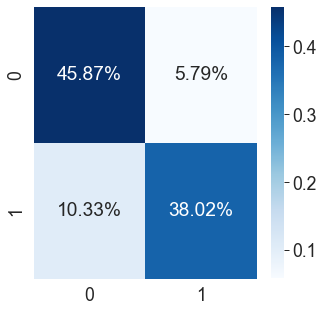

In [170]:
cf_matrix = confusion_matrix(Y_test,pred)
fig = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

plt.savefig('graficos/cf.eps')

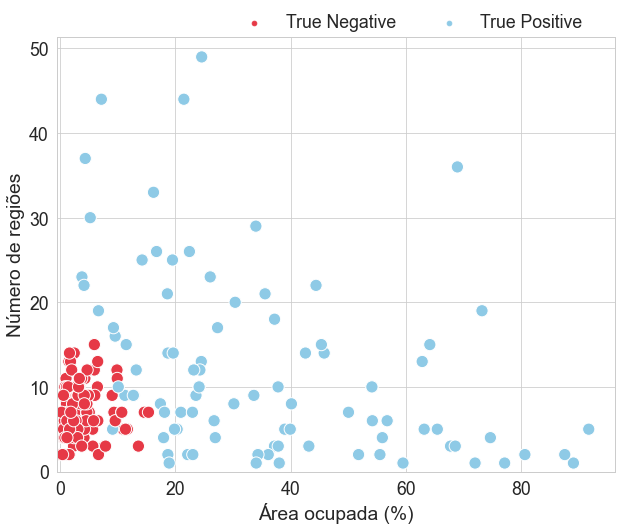

In [172]:
fig = plt.figure(figsize = (10,8))

sns.set_theme(style = 'whitegrid')
sns.set_context(context='paper',font_scale=2)

sns.scatterplot(
    data=X_test[X_test['class'].isin(['True Positive','True Negative'])], 
    x="area_ocupada", 
    y="numero_regioes", 
    hue="class",
    s = 150,
    palette = {
        'True Positive':'#8ecae6',
        'True Negative':'#e63946',
    }
)

plt.xlabel(
    'Área ocupada (%)', 
    #fontsize = 15
    )
plt.ylabel(
    'Número de regiões', 
    #fontsize = 15
    )

#plt.legend(['True Positive','oi'])

plt.legend(
    #['True Positive','True Negative'],
    bbox_to_anchor=(0.45,1.09, 0.52, 0), 
    ncol=2,
    #fontsize=18,
    frameon=False
    )


#plt.rcParams['xtick.labelsize']=18
#plt.rcParams['ytick.labelsize']=18

plt.xlim(left = -0.5)
plt.ylim(bottom= 0)

plt.savefig(
    f'./graficos/true.eps',
    dpi=1200,
    bbox_inches='tight'
)

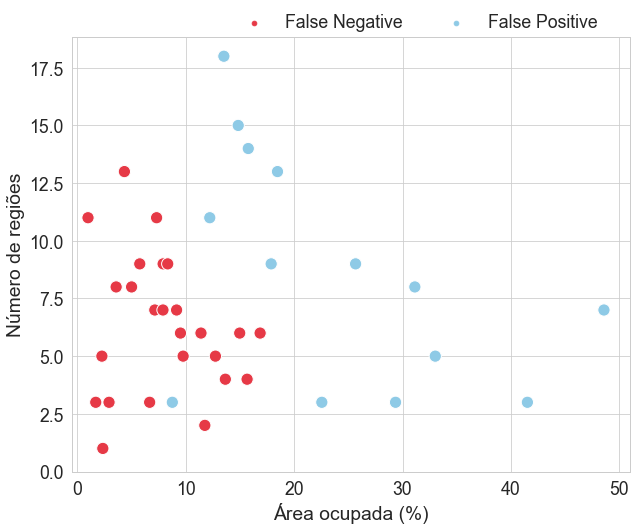

In [171]:
fig = plt.figure(figsize = (10,8))

sns.set_theme(style = 'whitegrid')
sns.set_context(context='paper',font_scale=2)

sns.scatterplot(
    data=X_test[X_test['class'].isin(['False Positive','False Negative'])], 
    x="area_ocupada", 
    y="numero_regioes", 
    hue="class",
    s = 150,
    palette = {
        'False Positive':'#8ecae6',
        'False Negative':'#e63946',
    }
)

plt.xlabel(
    'Área ocupada (%)', 
    #fontsize = 15
    )
plt.ylabel(
    'Número de regiões', 
    #fontsize = 15
    )

#plt.legend(['True Positive','oi'])

plt.legend(
    #['True Positive','True Negative'],
    bbox_to_anchor=(0.45,1.09, 0.52, 0), 
    ncol=2,
    #fontsize=18,
    frameon=False
    )


#plt.rcParams['xtick.labelsize']=18
#plt.rcParams['ytick.labelsize']=18

plt.xlim(left = -0.5)
plt.ylim(bottom= 0)

plt.savefig(
    f'./graficos/false.eps',
    dpi=1200,
    bbox_inches='tight'
)

In [104]:
def classify_and_plot(X, y):
    ''' 
    split data, fit, classify, plot and evaluate results 
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 41)

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold  = ListedColormap(['#FF0000', '#0000FF'])

    rcParams['figure.figsize'] = 5, 5

    clf = neighbors.KNeighborsClassifier(n_neighbors = 21)
    clf.fit(X_train, y_train)

    X = np.array(X)
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)   
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("Resultado KNN(k = 21)")
    plt.show()
    fig.savefig('./graficos/knn.png')

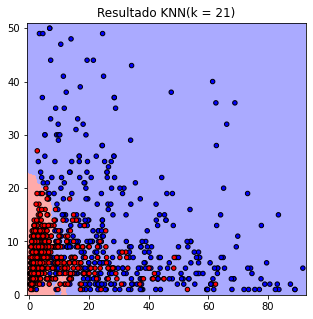

In [105]:
classify_and_plot(X,Y)